<h2>Imports

In [13]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix,f1_score
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv('../Data/address_data_combined.csv')

In [15]:
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [16]:
import numpy as np

columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance']
    
scaler = MinMaxScaler()

# Log for Skewed Data
for c in columns:
  X_train[c] = X_train[c].apply(lambda x: np.log(x) if x > 0 else 0)
  X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

np.isnan(X_train)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [4]:
params = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(1000,1500,100),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [5]:
clf = XGBClassifier(
    objective= 'binary:logistic',
    seed=42
)

In [6]:
tuned_clf = GridSearchCV(estimator=clf,
                         param_grid=params,
                         scoring='f1',
                         cv=5,
                         verbose=2,
                         )

In [7]:
tuned_clf.fit(X_train_full,y_train_full)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   2.5s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   3.0s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   2.4s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   2.0s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   2.0s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   2.1s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   2.2s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   2.4s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   2.6s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   2.8s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1200; total time=   3.1s
[CV] END ..learning_rate=0.1, max_depth=2, n_e

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(1000, 1500, 100)},
             scoring='f1', verbose=2)

In [10]:
print("Tuned Hyperparameters :", tuned_clf.best_params_)
print("Train F1 Score :",tuned_clf.best_score_)
best_y_pr = tuned_clf.predict(X_test)
print('Test F1 Score: ', f1_score(y_test, best_y_pr))

Tuned Hyperparameters : {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000}
Train F1 Score : 0.9267418174055969
Test F1 Score:  0.9353767560664112


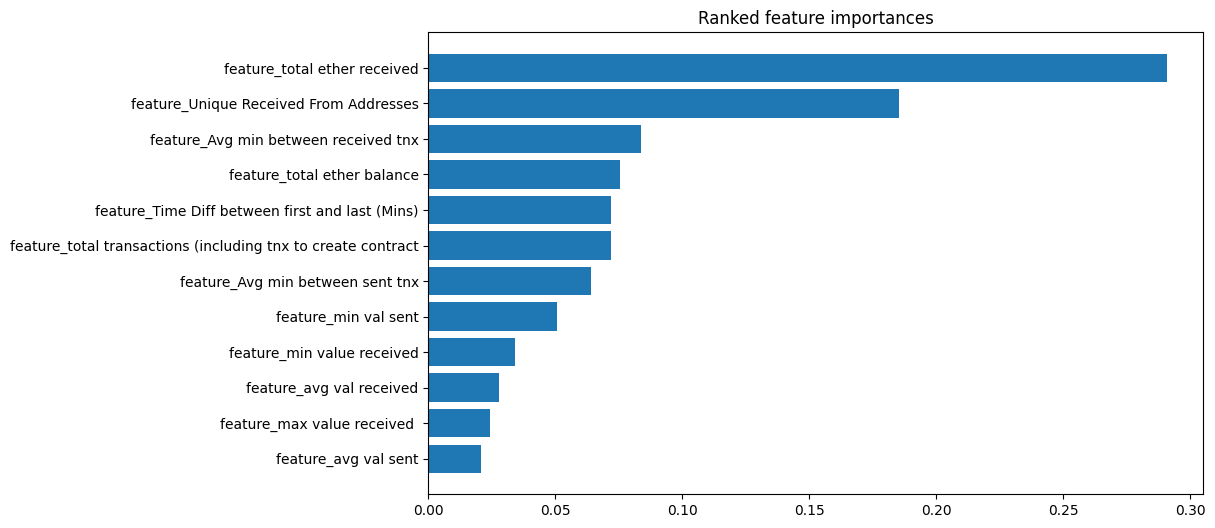

In [18]:
from matplotlib import pyplot as plt
feat_importances = tuned_clf.best_estimator_.feature_importances_
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();

In [21]:
tuned_clf.best_estimator_

XGBClassifier(learning_rate=0.05, max_depth=8, n_estimators=1000, seed=42)

In [22]:
tuned_clf.best_score_

0.9266381742653895

In [23]:
    y_pred = tuned_clf.predict(X_test)
    xgb_accuracy_score = accuracy_score(y_test, y_pred)
    xgb_auc_score = roc_auc_score(y_test, y_pred)
    print('XGBoost model accuracy score: {0:0.4f} '
      'and roc_auc score: {0:0.4f}'. format(xgb_accuracy_score,xgb_auc_score))

XGBoost model accuracy score: 0.9402 and roc_auc score: 0.9402


<h2>Loading of data

<h2>Model Training

In [ ]:
x_train_list = []
y_train_list = []
x_test_list = []
y_test_list = []

for i in range(10):
    y_train_new= train_list[i]['FLAG']
    y_test_new = test_list[i]['FLAG']

    x_train_new = train_list[i].drop(columns=['Address','FLAG'])
    x_test_new = test_list[i].drop(columns=['Address','FLAG'])

    x_train_list.append(x_train_new)
    y_train_list.append(y_train_new)
    x_test_list.append(x_test_new)
    y_test_list.append(y_test_new)

Used GridsearchCV for hyperparameter tuning and Manual cross validation

In [ ]:
accuracy_and_auc_score_list = []
for i in range(10):
    params = {
    'objective': ['binary:logistic'],
    'max_depth': [8],
    'learning_rate': [0.05],
    'n_estimators': [1000],
    }

    xgb_model = XGBClassifier()
    tuned_xgb = GridSearchCV(xgb_model,params,n_jobs=5,scoring='roc_auc',refit=True)
    tuned_xgb.fit(x_train_list[i],y_train_list[i])
    y_pred = tuned_xgb.predict(x_test_list[i])
    xgb_accuracy_score = accuracy_score(y_test_list[i], y_pred)
    xgb_auc_score = roc_auc_score(y_test_list[i], y_pred)
    item = [xgb_accuracy_score,xgb_auc_score]
    accuracy_and_auc_score_list.append(item)
    print('XGBoost model accuracy score: {0:0.4f} '
      'and roc_auc score: {0:0.4f}'. format(xgb_accuracy_score,xgb_auc_score))

XGBoost model accuracy score: 0.9581 and roc_auc score: 0.9581
XGBoost model accuracy score: 0.9581 and roc_auc score: 0.9581
XGBoost model accuracy score: 0.9517 and roc_auc score: 0.9517
XGBoost model accuracy score: 0.9555 and roc_auc score: 0.9555
XGBoost model accuracy score: 0.9530 and roc_auc score: 0.9530
XGBoost model accuracy score: 0.9536 and roc_auc score: 0.9536
XGBoost model accuracy score: 0.9441 and roc_auc score: 0.9441
XGBoost model accuracy score: 0.9460 and roc_auc score: 0.9460
XGBoost model accuracy score: 0.9562 and roc_auc score: 0.9562
XGBoost model accuracy score: 0.9581 and roc_auc score: 0.9581


<h2>Model Performance per K-Fold

In [ ]:
model_performance = pd.DataFrame(accuracy_and_auc_score_list)
model_performance.columns = ['Accuracy score', 'Roc_auc score']
model_performance

,Accuracy score,Roc_auc score
0,0.958095,0.958265
1,0.958069,0.958276
2,0.951715,0.951443
3,0.955527,0.955631
4,0.952986,0.952986
5,0.953621,0.953605
6,0.944091,0.944018
7,0.945997,0.945840
8,0.956163,0.956081
9,0.958069,0.958235


<h2>Overall Average Performance

In [ ]:
print('Mean Accuracy Score: {}'.format(model_performance['Accuracy score'].mean()))
print('Mean Roc_auc Score: {}'.format(model_performance['Roc_auc score'].mean()))

Mean Accuracy Score: 0.9534334119924971
Mean Roc_auc Score: 0.9534381921631996


<h2>Model Confusion Matrix and Statistics

Model Confusion Matrix Statistics:

 recall: 0.9517

 false_neg_rate: 0.0483

 false_pos_rate: 0.0352

 true_neg_rate: 0.9648

 positive_liklihood_ratio: 27.0346

 neg_liklihood_rate: 0.0501

 precision: 0.9660

 false_omission_rate: 0.0501

 false_discovery_rate: 0.0340

 neg_pred_value: 0.9499

 markedness: 0.9160

 diagnostic_odds_ration: 539.7151

 informedness: 0.9165

 prevalence_threshold: 0.1613

 prevalence: 0.5127

 accuracy: 0.9581

 balanced_accuracy: 0.9582

 F1_score: 0.9588

 fowlkes_mallows_index: 0.9588

 jaccard_index: 0.9209


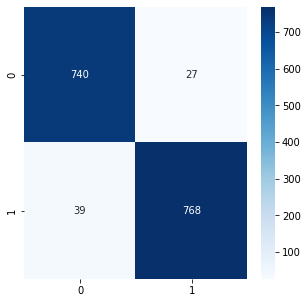

In [ ]:
def model_diagnostic_stats(confusion_matrix):
    tp = confusion_matrix[1,1]
    tn = confusion_matrix[0,0]
    fp = confusion_matrix[0,1]
    fn = confusion_matrix[1,0]

    p = tp + fn
    n = fp + tn
    pp = tp + fp
    pn = fn + tn

    diagnostic_dict = {
    'recall' : tp/p,
    'false_neg_rate' : fn/p,
    'false_pos_rate' : fp/n,
    'true_neg_rate' : tn/n,
    'positive_liklihood_ratio' : (tp/p)/(fp/n),
    'neg_liklihood_rate' : (fn/p)/(tn/n),
    'precision' : tp/pp,
    'false_omission_rate' : fn/pn,
    'false_discovery_rate' : fp/pp,
    'neg_pred_value' : tn/pn,
    'markedness' : (tp/pp)+(tn/pn)-1,
    'diagnostic_odds_ration' : ((tp/p)/(fp/n))/( (fn/p)/(tn/n)),
    'informedness' : (tp/p)+(tn/n)-1,
    'prevalence_threshold' : (sqrt((tp/p)*(fp/n))-(fp/n))/((tp/p)-(fp/n)),
    'prevalence' : p/(p+n),
    'accuracy' : (tp+tn)/(p+n),
    'balanced_accuracy' : ((tp/p)+(tn/n))/2,
    'F1_score' : 2*tp/(2*tp+fp+fn),
    'fowlkes_mallows_index' : sqrt((tp/pp)*(tp/p)),
    'jaccard_index' : tp/(tp+fn+fp),
    }

    return diagnostic_dict
cm_matrix = confusion_matrix(y_test_list[9],y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sb.heatmap(cm_matrix,annot=True,fmt='g',cmap="Blues")
stats = model_diagnostic_stats(cm_matrix)
print('Model Confusion Matrix Statistics:')
for key,value in stats.items():
    value_str = '%.4f' % value
    print("\n {}: {}".format(key,value_str))


<h2>Feature Importance Plot

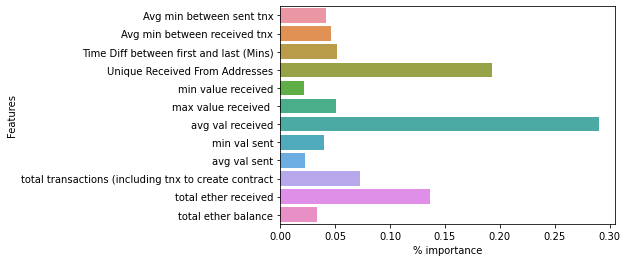

In [ ]:
feature_importances = tuned_xgb.best_estimator_.feature_importances_
column_var = x_train_list[0].columns.tolist()
feature_imprt_df = pd.DataFrame({'Features':column_var, '% importance': feature_importances})
formatted_vars_display = [ '%.3f' % elem for elem in feature_importances ]
ax = sb.barplot(x='% importance', y='Features',data=feature_imprt_df)
ax.set(xlabel='% importance', ylabel='Features')
plt.show()
